In [49]:
import pandas as pd
import pm4py
import matplotlib.pyplot as plt
from typing import Optional, Set, FrozenSet
import numpy as np
import networkx as nx
import seaborn as sns

In [2]:
path = "C://Users//ramae//OneDrive//Documents//Uni//Master Jaar 2//Process Mining//Group Project//data//BPI2017Denied(3).xes"

In [3]:
log = pm4py.read_xes(path)

c:\Users\ramae\OneDrive\Documents\Uni\Master Jaar 2\Process Mining\Group Project\.venv\Lib\site-packages\pm4py\utils.py:800: UserWarning: Install the optional requirement `rustxes` to import/export files faster.
  warnings.warn("Install the optional requirement `rustxes` to import/export files faster.")
c:\Users\ramae\OneDrive\Documents\Uni\Master Jaar 2\Process Mining\Group Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 3093/3093 [00:04<00:00, 728.04it/s]


In [4]:
log.head()

Action org:resource             concept:name  EventOrigin  \
0      Created       User_1                    start  Application   
1      Created       User_1     A-Create-Application  Application   
2  statechange       User_1              A-Submitted  Application   
3      Created       User_1  W-Handle-leads-schedule     Workflow   
4      Deleted       User_1  W-Handle-leads-withdraw     Workflow   

                  EventID lifecycle:transition  \
0  Application_1691306052             complete   
1  Application_1691306052             complete   
2     ApplState_284636842             complete   
3      Workitem_831373279             schedule   
4     Workitem_1299098074             withdraw   

                    time:timestamp     case:LoanGoal  case:RequestedAmount  \
0 2016-01-01 11:16:11.500000+00:00  Home improvement               10000.0   
1 2016-01-01 11:16:11.500000+00:00  Home improvement               10000.0   
2 2016-01-01 11:16:11.549000+00:00  Home improvement               10000.0   
3 2016-01-01 11:16:11.740000+00:00  Home improvement               10000.0   
4 2016-01-01 11:17:31.573000+00:00  Home improvement               10000.0   

  case:ApplicationType       case:concept:name  FirstWithdrawalAmount  \
0           New credit  Application_1691306052                    NaN   
1           New credit  Application_1691306052                    NaN   
2           New credit  Application_1691306052                    NaN   
3           New credit  Application_1691306052                    NaN   
4           New credit  Application_1691306052                    NaN   

   NumberOfTerms Accepted  MonthlyCost Selected  CreditScore  OfferedAmount  \
0            NaN      NaN          NaN      NaN          NaN            NaN   
1            NaN      NaN          NaN      NaN          NaN            NaN   
2            NaN      NaN          NaN      NaN          NaN            NaN   
3            NaN      NaN          NaN      NaN          NaN            NaN   
4            NaN      NaN          NaN      NaN          NaN            NaN   

  OfferID  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN

In [5]:
# Discover Petri net with Inductive Miner
net, im, fm = pm4py.discover_petri_net_inductive(log)

In [8]:
# Export Petri net
gviz_pn = pm4py.visualization.petri_net.visualizer.apply(net, im, fm)


In [9]:
pm4py.visualization.petri_net.visualizer.save(gviz_pn, "petri_net.png")

''

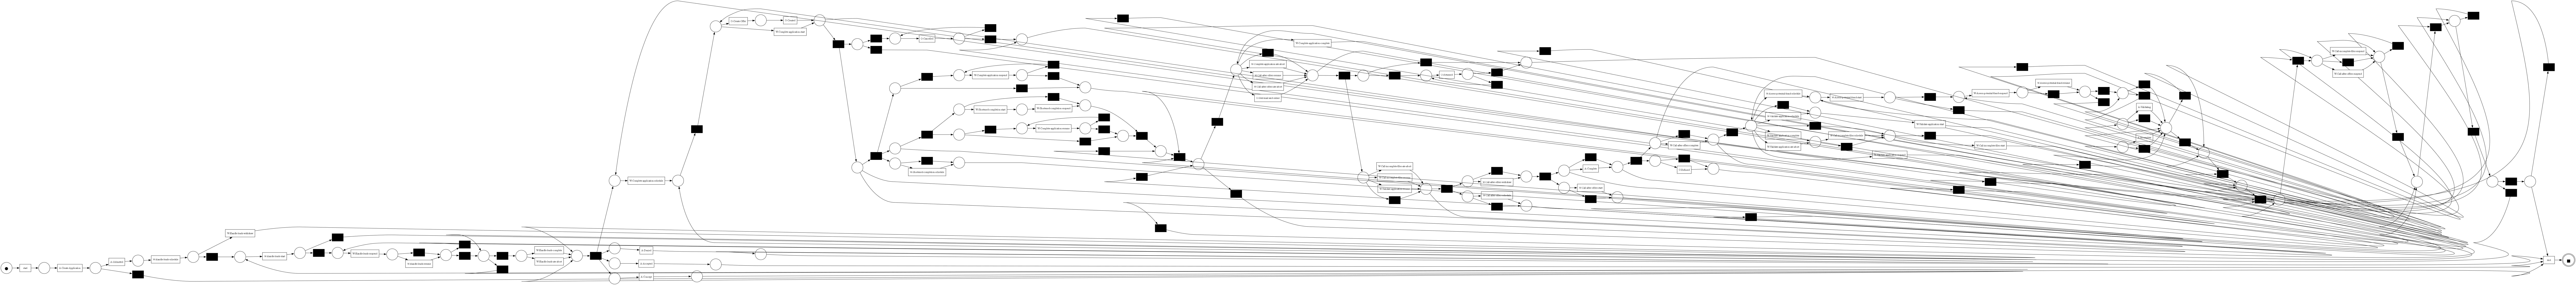

In [7]:
pm4py.visualization.petri_net.visualizer.view(gviz_pn)

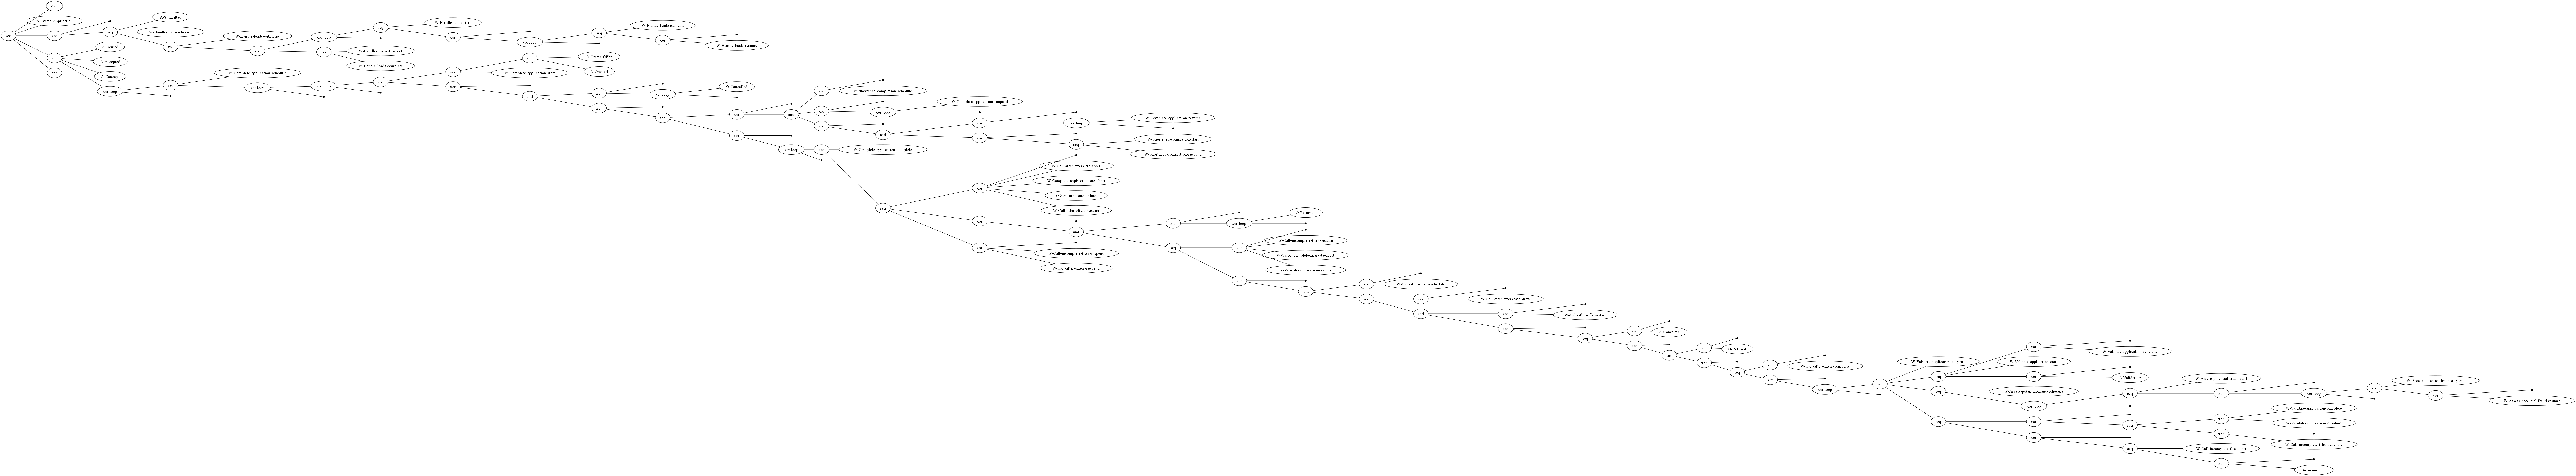

''

In [10]:
# Convert to process tree
pt = pm4py.convert_to_process_tree(net, im, fm)

# Visualize process tree
gviz_pt = pm4py.visualization.process_tree.visualizer.apply(pt)
pm4py.visualization.process_tree.visualizer.view(gviz_pt)
pm4py.visualization.process_tree.visualizer.save(gviz_pt, "process_tree.png")

In [12]:
from pm4py.objects.process_tree.obj import ProcessTree, Operator

def get_leaf_activities(node):
    if node.label is not None:  # leaf activity
        return {node.label}
    acts = set()
    for child in node.children:
        acts |= get_leaf_activities(child)
    return acts

def extract_parallel_pairs(node):
    pairs = set()
    if node.operator == Operator.PARALLEL:
        children_sets = [get_leaf_activities(c) for c in node.children]
        for i in range(len(children_sets)):
            for j in range(i+1, len(children_sets)):
                for a in children_sets[i]:
                    for b in children_sets[j]:
                        pairs.add(frozenset([a, b]))
    for child in node.children:
        pairs |= extract_parallel_pairs(child)
    return pairs

parallel_pairs = extract_parallel_pairs(pt)
print("Detected parallel pairs:", parallel_pairs)

Detected parallel pairs: {frozenset({'O-Refused', 'W-Call-after-offers-schedule'}), frozenset({'W-Assess-potential-fraud-suspend', 'W-Call-after-offers-schedule'}), frozenset({'A-Incomplete', 'W-Call-after-offers-schedule'}), frozenset({'A-Complete', 'O-Returned'}), frozenset({'W-Call-incomplete-files-ate-abort', 'O-Returned'}), frozenset({'W-Complete-application-suspend', 'W-Shortened-completion-start'}), frozenset({'W-Complete-application-start', 'A-Denied'}), frozenset({'W-Assess-potential-fraud-schedule', 'A-Accepted'}), frozenset({'O-Refused', 'A-Denied'}), frozenset({'W-Complete-application-start', 'A-Concept'}), frozenset({'O-Refused', 'A-Concept'}), frozenset({'W-Call-incomplete-files-schedule', 'W-Call-after-offers-schedule'}), frozenset({'O-Cancelled', 'W-Call-after-offers-resume'}), frozenset({'A-Denied', 'O-Returned'}), frozenset({'W-Shortened-completion-schedule', 'A-Denied'}), frozenset({'A-Concept', 'O-Returned'}), frozenset({'W-Shortened-completion-schedule', 'A-Concept

In [ ]:
# Define ParallelPairs as a type alias for better readability
ParallelPairs = Set[FrozenSet[str]]

def compute_handover_matrix(
    log_df: pd.DataFrame,
    case_col: str = "case_id",
    activity_col: str = "activity",
    resource_col: str = "resource",
    timestamp_col: Optional[str] = None,
    parallel_pairs: Optional[ParallelPairs] = None,
) -> pd.DataFrame:
    """
    Compute mean number of handovers (from resource r1 to r2) per case.

    Parameters
    ----------
    log_df : pandas.DataFrame
        Event log: one row per event.
    case_col, activity_col, resource_col : str
        Column names
    timestamp_col : str or None
        If provided, rows PER CASE are sorted by this column. If None, it assumes
        the rows are already ordered in case order.
    parallel_pairs : set of frozensets or None
        Set containing unordered pairs of activities that are parallel.
        If None, no activity is considered parallel.

    Returns
    -------
    handover_df : pandas.DataFrame
        DataFrame indexed / columns by resource names, with values = mean handovers per case.
    """

    if parallel_pairs is None:
        parallel_pairs = set()

    # distinct resources
    resources = sorted(log_df[resource_col].dropna().unique().tolist())
    r_index = {r: i for i, r in enumerate(resources)}
    n = len(resources)

    # total handover counts across all cases (directed)
    total_counts = np.zeros((n, n), dtype=float)

    # number of cases (denominator)
    cases = log_df[case_col].unique()
    n_cases = len(cases)
    if n_cases == 0:
        raise ValueError("Empty log or no cases found.")

    # group by case
    grouped = log_df.groupby(case_col)

    for case_id, group in grouped:
        # ensure events in this case are ordered
        if timestamp_col is not None:
            group_sorted = group.sort_values(timestamp_col, kind="mergesort")
        else:
            # preserve original order within group
            group_sorted = group

        # iterate consecutive pairs
        events = group_sorted[[activity_col, resource_col]].values
        # events is list of rows [activity, resource]
        for i in range(len(events) - 1):
            act_i, res_i = events[i]
            act_j, res_j = events[i + 1]

            # skip missing resources or activities
            if pd.isna(res_i) or pd.isna(res_j) or pd.isna(act_i) or pd.isna(act_j):
                continue

            # same resource -> not a handover
            if res_i == res_j:
                continue

            # skip if activities are model-declared parallel
            if frozenset([act_i, act_j]) in parallel_pairs:
                continue

            # otherwise increment handover count res_i -> res_j
            if res_i in r_index and res_j in r_index:
                total_counts[r_index[res_i], r_index[res_j]] += 1.0

    # mean per case
    mean_per_case = total_counts / float(n_cases)

    handover_df = pd.DataFrame(mean_per_case, index=resources, columns=resources)
    return handover_df




In [19]:
handover_df = compute_handover_matrix(
    log_df=log,                 
    case_col="case:concept:name",
    activity_col="concept:name",
    resource_col="org:resource",
    timestamp_col="time:timestamp",
    parallel_pairs=parallel_pairs
)

print(handover_df)

            User_1   User_10  User_100  User_101  User_102  User_104  \
User_1    0.000000  0.003233  0.000000  0.000000  0.000000  0.000000   
User_10   0.000647  0.000000  0.000000  0.000000  0.000000  0.000000   
User_100  0.000647  0.000323  0.000000  0.000647  0.000970  0.000000   
User_101  0.000000  0.000000  0.000323  0.000000  0.000000  0.000000   
User_102  0.000000  0.000000  0.000647  0.000323  0.000000  0.000000   
...            ...       ...       ...       ...       ...       ...   
User_93   0.000000  0.000323  0.000970  0.000000  0.000000  0.000000   
User_95   0.000647  0.000000  0.000000  0.000000  0.000647  0.000000   
User_96   0.000323  0.000000  0.000000  0.000000  0.000000  0.000323   
User_97   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
User_99   0.000000  0.000000  0.000323  0.000000  0.000323  0.000000   

          User_106  User_107  User_108  User_109  ...  User_89    User_9  \
User_1     0.00097   0.00000       0.0  0.000000  ...      

In [43]:
def handover_network_from_matrix(
    handover_df: pd.DataFrame,
    threshold: float = 0.0,
    directed: bool = True,
    show_unconnected_nodes: bool = False
) -> nx.Graph | nx.DiGraph:
    """
    Create a NetworkX graph from a handover DataFrame.
    Only edges with weight >= threshold are included.

    Parameters
    ----------
    handover_df : pandas.DataFrame
        index and columns are resource names; values are mean handovers per case
    threshold : float
        Minimum edge weight to keep
    directed : bool
        If False, returns an undirected graph (weight = mean of both directions)
    show_unconnected_nodes : bool
        If True, nodes without meaningful edges are included.

    Returns
    -------
    G : networkx.DiGraph or Graph
    """
    G = nx.DiGraph() if directed else nx.Graph()

    if directed:
        for src in handover_df.index:
            for dst in handover_df.columns:
                w = handover_df.at[src, dst]
                if w >= threshold and w > 0:
                    G.add_edge(src, dst, weight=float(w))
        if show_unconnected_nodes:
            for node in handover_df.index:
                G.add_node(node)
    else:
        visited = set()
        for a in handover_df.index:
            for b in handover_df.columns:
                if (a, b) in visited or (b, a) in visited:
                    continue
                w = (handover_df.at[a, b] + handover_df.at[b, a]) / 2.0
                if w >= threshold and w > 0:
                    G.add_edge(a, b, weight=float(w))
                visited.add((a, b))
        if show_unconnected_nodes:
            for node in handover_df.index:
                G.add_node(node)

    return G

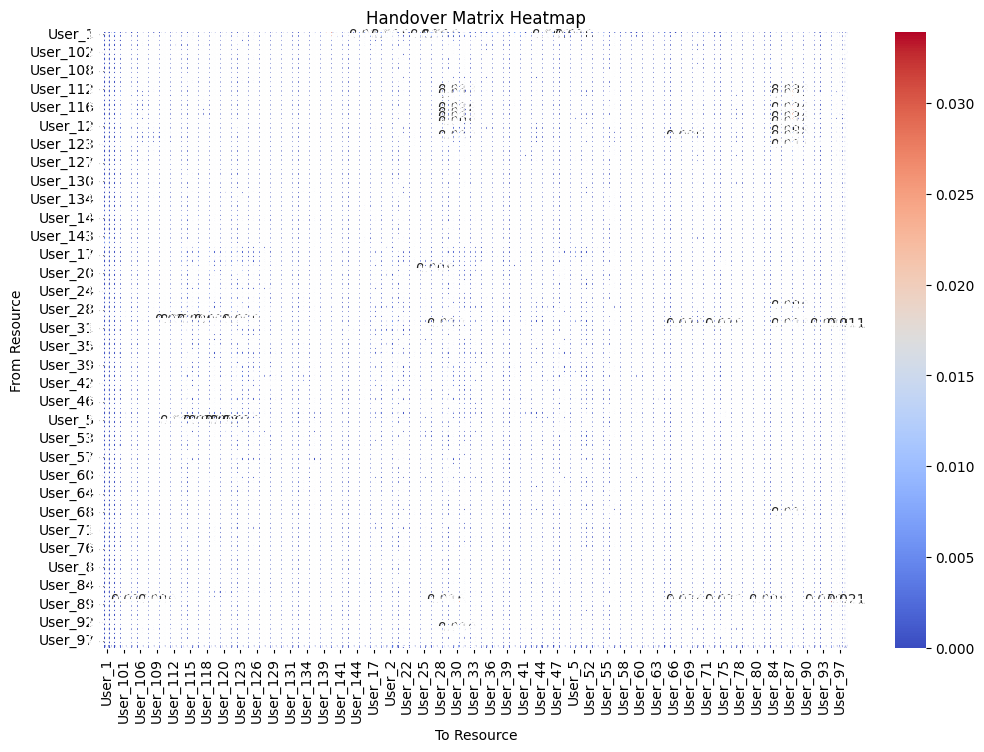

In [50]:
# Visualize the handover matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(handover_df, annot=True, fmt=".3f", cmap="coolwarm", cbar=True)
plt.title("Handover Matrix Heatmap")
plt.xlabel("To Resource")
plt.ylabel("From Resource")
plt.show()

In [ ]:
# Visualize matrix (it is demand in assignment to visualize)
print(handover_df.round(3))

          User_1  User_10  User_100  User_101  User_102  User_104  User_106  \
User_1     0.000    0.003     0.000     0.000     0.000       0.0     0.001   
User_10    0.001    0.000     0.000     0.000     0.000       0.0     0.000   
User_100   0.001    0.000     0.000     0.001     0.001       0.0     0.000   
User_101   0.000    0.000     0.000     0.000     0.000       0.0     0.000   
User_102   0.000    0.000     0.001     0.000     0.000       0.0     0.000   
...          ...      ...       ...       ...       ...       ...       ...   
User_93    0.000    0.000     0.001     0.000     0.000       0.0     0.001   
User_95    0.001    0.000     0.000     0.000     0.001       0.0     0.000   
User_96    0.000    0.000     0.000     0.000     0.000       0.0     0.000   
User_97    0.000    0.000     0.000     0.000     0.000       0.0     0.000   
User_99    0.000    0.000     0.000     0.000     0.000       0.0     0.000   

          User_107  User_108  User_109  ...  User_8

In [46]:
# Get network with threshold 0.02 mean handovers per case
G = handover_network_from_matrix(handover_df, threshold=0.01, show_unconnected_nodes=False)

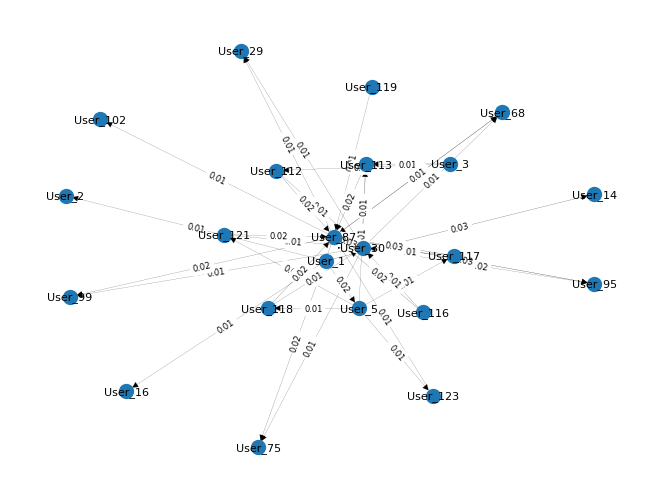

In [48]:
pos = nx.spring_layout(G, seed=42)
weights = [G[u][v]['weight'] for u,v in G.edges()]
nx.draw(G, pos, with_labels=True, node_size=100, width=[max(0.1, w*5) for w in weights], font_size=8)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f"{v:.2f}" for k, v in edge_labels.items()}, font_size=6)
plt.show()